# Algorithm for vibration calculation (made by Roman Bokhyan)
## In this part I will propose an algorithm that realizes the calculation of vibrations of an object from a video recorded on a special high-speed camera (which allows you to shoot up to several thousand FPS). The algorithm will be implemented in Python using the following libraries.
#### NumPy
It is a library for working with arrays and matrices, which also includes functions for performing mathematical operations on these data structures.
Usage:
Creating and manipulating multidimensional arrays (e.g., vectors, matrices).
Performing mathematical operations (e.g., linear algebra, statistics).
Processing data and performing high performance calculations.
#### OpenCV:
OpenCV (Open Source Computer Vision Library) is a library designed for image processing and computer vision.
Usage:
Loading, saving and processing images and videos.
Performing various operations on images (e.g. resizing, rotating, filtering, segmenting).
Recognizing objects, faces, text, and other elements in images.
Analyze and process video streams in real time.
#### Random
The random module in Python provides functions for generating random numbers, selecting random elements from sequences, and performing other operations related to randomness.
Usage:
Generating random numbers: Generate random integers, floating point numbers, and other types of random data.
Selecting random elements: Selecting a random element or multiple elements from a list, tuple, or other sequence.
Shuffle Sequences: Randomly shuffle elements of a list.
Random Samples: Create data samples randomly.
#### SciPy.fft:
SciPy is a library for scientific and technical computing. The fft submodule is used to perform fast Fourier transforms (FFT).
Usage:
Transforming signals and images from the time (or spatial) domain to the frequency domain and back.
Analyzing the frequency characteristics of signals.
Filtering and signal processing.
#### OS
The os module in Python provides functions for interacting with the operating system.
Usage:
Managing files and directories (e.g., creating, deleting, moving files and folders).
Executing system commands.
Getting information about the file system and environment.
#### Matplotlib.pyplot
Description:
matplotlib.pyplot is a module from the Matplotlib library that provides functions for graphing and data visualization. It provides an interface for creating various types of graphs and charts in a style similar to MATLAB.
Usage:
Graph Building: Create various types of graphs such as line graphs, histograms, scatter graphs, bar graphs and many more.
Graph Customization: Customize axes, headers, labels, legends, and other graph elements to improve the appearance and ease of data interpretation.
Image Visualization: Display images in a variety of color spaces and formats.
Graph Saving: Saves created graphs in various image formats such as PNG, JPEG, PDF, etc.
#### Concurrent.futures.ThreadPoolExecutor
concurrent.futures.ThreadPoolExecutor is a class from the Python standard library that provides a convenient way to execute tasks in parallel using a thread pool. A thread pool is a group of threads that are managed and used to execute tasks in parallel.
Usage:
Parallel task execution: Allows multiple tasks to run concurrently, which can greatly speed up program execution, especially if the tasks can run independently of each other.
Thread Management: ThreadPoolExecutor manages the creation, destruction, and reuse of threads, which simplifies code and makes it more efficient.
Synchronization: Provides methods to wait for tasks to complete and retrieve their results.

In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift
import cv2
import os
import random
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

## Part 1. Preparing the data
My colleague has prepared special noise-cleared footage of the subject and I will use it for work.

In [2]:
frames_directory = "preped_data/filtered_event_frames"
video_path = "raw_data/high_speed_cam_videos/MotorAmplif_motion_evm_2022-12-23-10-50-19.mp4"

Let's unload our frames into an array. I will also do a first comparative analysis, which will show a way to speed up the calculations.

In [3]:
import time


# Function for sequential frame reading
def read_frames_into_array_sequential(directory_path):
    frames = []
    for filename in sorted(os.listdir(directory_path)):
        frame_path = os.path.join(directory_path, filename)
        frame = cv2.imread(frame_path)
        frames.append(frame)
    return frames


# Function for parallel frame reading
def read_frames_into_array_parallel(directory_path):
    def read_frame(frame_name):
        frame_path = os.path.join(directory_path, frame_name)
        return cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

    frame_names = sorted(os.listdir(directory_path))

    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        frames = list(executor.map(read_frame, frame_names))

    return frames


# Function for measuring runtime
def measure_time(func, *args):
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    return end_time - start_time


Number of frames: 85


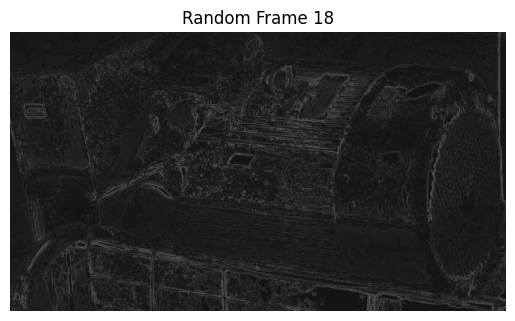

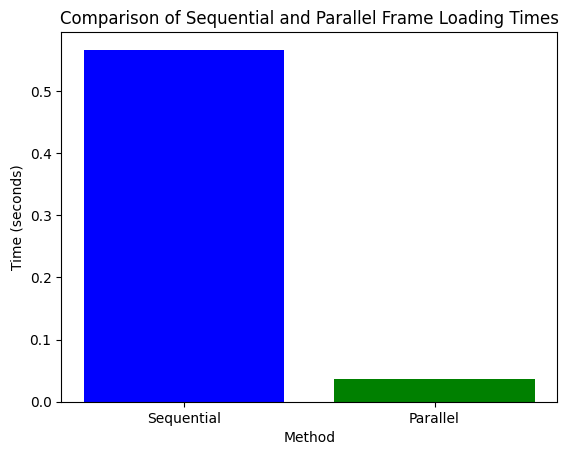

Sequential loading time: 0.5663 seconds
Parallel loading time: 0.0360 seconds
Speedup: 15.73 times


In [4]:
frames = read_frames_into_array_parallel(frames_directory)
print(f"Number of frames: {len(frames)}")
random_index = random.randint(0, len(frames) - 1)
random_frame = frames[random_index]
random_frame_rgb = cv2.cvtColor(random_frame, cv2.COLOR_BGR2RGB)
plt.imshow(random_frame_rgb)
plt.title(f"Random Frame {random_index}")
plt.axis('off')
plt.show()

sequential_time = measure_time(read_frames_into_array_sequential, frames_directory)
parallel_time = measure_time(read_frames_into_array_parallel, frames_directory)

# Visualization of results
methods = ['Sequential', 'Parallel']
times = [sequential_time, parallel_time]

plt.bar(methods, times, color=['blue', 'green'])
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
plt.title('Comparison of Sequential and Parallel Frame Loading Times')
plt.show()

print(f"Sequential loading time: {sequential_time:.4f} seconds")
print(f"Parallel loading time: {parallel_time:.4f} seconds")
print(f"Speedup: {sequential_time / parallel_time:.2f} times")

As you can see above, I have output the number of our frames as well as one random frame. We can also notice how much faster the parallel read algorithm is. creates a thread pool with the number of threads equal to the number of available CPU cores. This allows us to perform multiple operations in parallel. I will also use it in the subsequent work with frame handling.

## Part 2. Frame shifting

I will now introduce the mathematical concepts I used to make frame tracking work.
### Phase Correlation for Template Matching - PCTM
Phase correlation is a technique used to determine the relative shift between two images or frames. Its advantage over other methods is its robustness to illumination, making it an ideal way to analyze video recorded on a high-speed camera. This method uses the Fourier transform to translate the image into the frequency domain (it is important to note that Fourier translates regardless of the position of the object in the frame). The phase correlation itself calculates the cross power spectrum of two frames, which allows you to accurately determine the shifts between them, including if they are not just pixils but subpixils.
### Fourier Transform
Before describing the Fourier application in our case, there will be a brief explanation of what a Fourier transform is. *The Fourier transform is a representation of an image as a sum of complex exponentials of varying magnitudes, frequencies, and phases. The Fourier transform plays a critical role in a broad range of image processing applications, including enhancement, analysis, restoration, and compression. Two formulas, Fourier transform and inverse Fourier transform, will be described below.

The discrete Fourier transform (DFT) of an image $ f $ of size $ M \times N $is an image $ F $ of the same size defined as:

$$
F(u,v) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} f(m,n) e^{-j\,2\pi \left(\frac{um}{M} + \frac{vn}{N}\right)}
$$

The inverse discrete Fourier transform computes the original image from its Fourier transform:

$$
f(m,n) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} F(u,v) e^{+j\,2\pi \left(\frac{um}{M} + \frac{vn}{N}\right)}
$$

For convenience, the Fourier series is denoted by $F$ for the Fourier transform and ${F}^{-1}$for the inverse Fourier transform, respectively.

A description of how the DFT and inverse Fourier transform work. Note that,$\textit{ the spatial domain}$ represents the location of pixels or points in the image space, and $\textit{the frequency domain}$ represents the change in signal intensity in that space, determining how fast the pixel values change.
### FFT in our case
- The input is an image (in spatial domain) (e.g. in our case it will be an event-frame) where each pixel has a different intensity.
- Direct Fourier applications. Using the 2D Fourier property that considers frequencies in two spatial axes we can transform each pixel of the image into a complex number that corresponds to a point in the frequency domain.
- Result. From the previous point, we have obtained a two-dimensional transformation of the frame in the frequency domain (there each point represents a certain frequency in the original frame). Such a frame will contain information about amplitude and phase of frequency components. This is what we plan to use for vibration extraction.
### Inverse FFT in our case
- As input we receive a frame in the frequency domain.
- We transform a frequency domain frame into a spatial domain frame by inverse Fourier transform.
- As a result, we obtain the original frame in the spatial domain.
### Cross power spectrum
The cross power spectrum is calculated by multiplying the Fourier transform of one frame by the complex conjugate Fourier transform of the other frame. This is done in order to extract common frequencies between two frames without considering moments that are not common to these frames.To accurately determine the shift between frames it is necessary to normalize the cross power spectrum, this is done because normalization ensures that the value of the spectrum does not affect the phase information.

$$
R(u, v) = \frac{G_a(u,v)G_b^*(u,v)}{|G_a(u,v)G_b^*(u,v)|}
$$

where  $G_a(u, v) $ and  $ G_b(u, v) $ are the  $ \mathcal{F} $ of the two images being compared, and  $ G_b^*(u, v) $ is the complex conjugate of  $G_b(u, v)  $. This process ensures that the result focuses solely on the phase difference between the images, which is used to calculate the shift.
### Window function
Window functions are very commonly used in FFT work. Since we need a periodic function to work, and most often when working with real video fragments we have so-called "spectral leaks (this is a phenomenon that occurs when Fourier is applied to a finite segment of a signal that does not contain an integer number of periods. As a result of this transformation, the energy of the signal "leaks" into neighboring frequencies, causing distortions in the spectral representation.)" Window functions just work with such parts, turning our function into a periodic function.

The video segments that most often need windowing functions are
- Videos with sharp transitions and breaks
- Videos with motion
- Videos with flickering
- Video with noise
In the context of the algorithm for measuring object vibrations, our video clips will obviously fit these types.

I will use the Hamming window, which is ideal for processing most video clips. This window allows you to work with correct data by effectively suppressing side lobes - additional peaks or waves surrounding the main lobe. The main lobe is the central part of the spectrum, containing the highest signal energy and basic frequency information.
#### Hamming Window

##### Hamming Window Formula

The Hamming Window is defined as follows:

$$
w(n) = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right)
$$

where:
- $ n $ is the index of the point in the window,
- $ N $ - total number of points in the window.

##### Description

Hamming window is used to reduce spectral leakage when applying Fast Fourier Transform (FFT). It smooths the edges of the signal to reduce sharp transitions that can cause distortion in the frequency domain. The Hamming window effectively suppresses side lobes, making it useful for signal analysis and image processing.

##### Applying the Hamming Window to a Frame

To apply the Hamming window to an image frame, each frame element is multiplied by the corresponding value from the window function. This is done on both the horizontal and vertical axes of the image. The result is a two-dimensional window that is multiplied by the original image.

In [5]:
def phase_correlation(f1, f2):
    F1 = fft2(f1 * np.hamming(f1.shape[0])[:, None] * np.hamming(f1.shape[1])[None, :])
    F2 = fft2(f2 * np.hamming(f2.shape[0])[:, None] * np.hamming(f2.shape[1])[None, :])

    R = F1 * np.conj(F2)
    R /= np.abs(R) if np.any(R) else 1

    shifted = fftshift(ifft2(R))
    abs_shifted = np.abs(shifted)

    rows = abs_shifted[:, 0].tolist()
    cols = abs_shifted[0, :].tolist()

    return rows, cols

In [6]:
def compute_shift(frame_pair):
    return phase_correlation(frame_pair[0], frame_pair[1])


In [7]:
def pattern_matching_on_frames(frames):
    shifts = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        future_shifts = [executor.submit(compute_shift, (frames[i], frames[i + 1]))
                         for i in range(len(frames) - 1)]
        for future in future_shifts:
            shift = future.result()
            shifts.append(shift)
    return shifts


The operation of the algorithm is as follows
- The algorithm works for a pair of two frames
- A two-dimensional Hamming window is created by multiplying one-dimensional Hamming windows on both axes (horizontal and vertical), then this window is multiplied by a frame
- The FFT of such a frame is calculated
- The cross power spectrum is calculated and then normalized
- fftshift (moving the zero frequency to the center of the spectrum for convenience of analysis)
- abs(shifted): Computing the amplitude of the complex spectrum obtained after the inverse Fourier transform (i.e., obtaining a number without the complex part)
- Extracting all values by columns (x, y axis) and converting them into a list for further work with them.


## Part 3. Vibration calculation
### Algorithm of Calculation of Vibrations Using Basic Physics

#### Determine the Time Intervals

Knowing the time between two consecutive frames ($dt$) is necessary to calculate the vibration frequency. For example, if a video is recorded at 30 frames per second, the interval between frames is

$
dt = \frac{1}{30} \text{ seconds}
$

#### Translate the Offsets into Vibration Amplitude

The offsets, which are determined using phase correlation, represent the distance in pixels. Translating these offsets into vibration amplitude depends on the physical scale if the size of a single pixel is known.

#### Use the Fourier Transform

Apply a Fast Fourier Transform (FFT) to the array of offsets to get the frequency spectrum of the vibration. The peak in the spectrum will give you the fundamental frequency of the vibration.


### Implementation of the Algorithm
I am going to measure the vibration of an object in the x (up down) and y (left right) axes. To do this, create a function that takes values from shifts (which we got above) and takes values for x and y axes from there.

In [8]:
def extract_shifts(frames_directory):
    shifts = pattern_matching_on_frames(frames)
    shifts_x = [s[0] for s in shifts]
    shifts_y = [s[1] for s in shifts]
    return shifts_x, shifts_y

Next, let's find the FPS of our video.

In [9]:
def get_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    return fps

Let's apply the vibration measurement algorithm.

In [10]:
def calculate_vibration(shifts):
    # FFT
    fft_result = np.fft.fft(shifts)
    # Getting the frequencies
    freqs = np.fft.fftfreq(len(shifts), d=(1 / frame_rate))
    # Getting the amplitudes
    amplitudes = np.abs(fft_result)
    return freqs, amplitudes

In [11]:
def plot_vibration(freqs, amplitudes, axis):
    plt.plot(freqs, amplitudes)
    plt.title(f"Vibration in {axis} axis")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

Let's load the data and visualize our values.

In [12]:
def plot_vibration(shifts, frame_rate, axis_name):
    fft_result = np.fft.fft(shifts)
    # Get the frequency spectrum
    freqs = np.fft.fftfreq(len(shifts), d=(1 / frame_rate))
    amplitudes = np.abs(fft_result)
    plt.figure(figsize=(10, 4))
    plt.plot(freqs[:len(freqs) // 2],
             amplitudes[:len(amplitudes) // 2])  # Display only the positive part of the spectrum
    plt.title(f'Vibration Frequency Spectrum along {axis_name}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

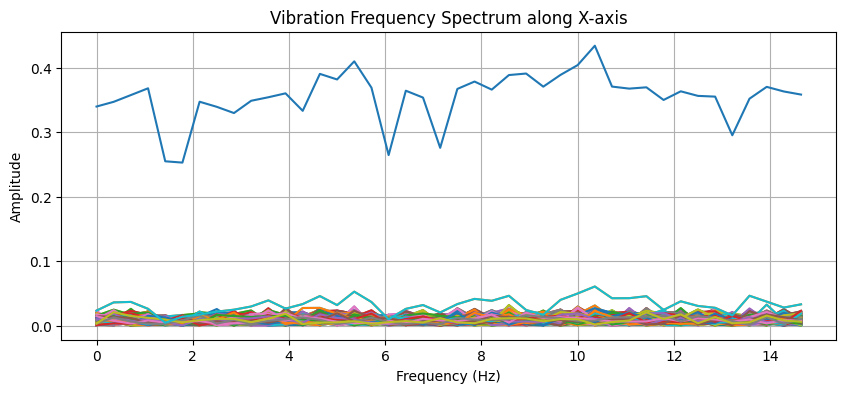

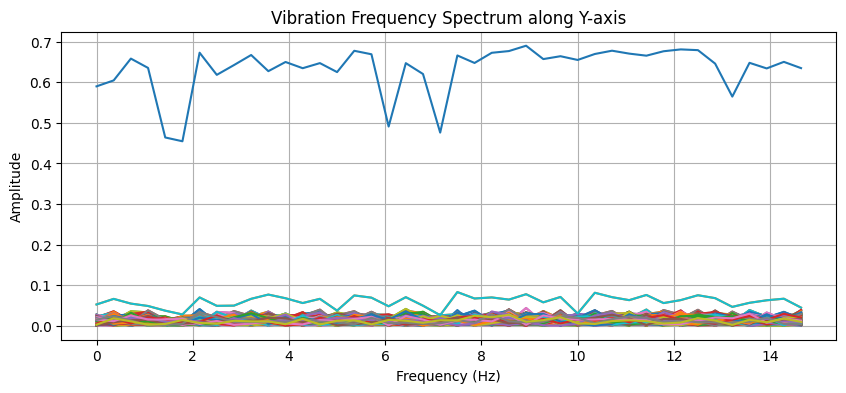

In [13]:
frame_rate = get_fps(video_path)
shifts_x, shifts_y = extract_shifts(frames_directory)
plot_vibration(shifts_x, frame_rate, 'X-axis')
plot_vibration(shifts_y, frame_rate, 'Y-axis')

### Explanation of the results of the vibration calculation algorithm

These two graphs show the results of the vibration calculation algorithm for the X and Y axes. It is worth paying attention to the blue line in each graph, as it represents significant vibrations. Values with low amplitudes indicate noise in the video and are not relevant to the object.

### Plot of the frequency spectrum of vibrations on the X-axis

- **Frequencies (Hz)**:
  - The horizontal axis indicates the frequencies in hertz (Hz) at which vibrations occur.
  - The frequency range is 0 to 15 Hz.
- **Amplitudes**:
  - The vertical axis indicates the amplitudes of the vibrations.
  - The maximum amplitude reaches approximately 0.4.
- **Main Observations**:
  - Peaks at frequencies around 1 Hz, 3 Hz, 6 Hz, 8 Hz, and 12 Hz indicate the presence of vibrations at these frequencies.
  - The amplitudes of the X-axis vibrations are relatively small, indicating weak vibrations of the object.

### Y-axis vibration frequency spectrum plot

- **Frequencies (Hz)**:
  - Frequency range from 0 to 15 Hz.
- **Amplitudes**:
  - The maximum amplitude reaches approximately 0.7.
- **Main Observations**:
  - Peaks at frequencies around 1 Hz, 3 Hz, 6 Hz, 8 Hz, and 12 Hz.
  - Vibration amplitudes in the Y-axis are higher than in the X-axis, indicating that the object oscillates more in this direction.



### Relation of amplitudes and frequencies

1. **Amplitude**:
   - Amplitude indicates the magnitude of the vibration. The higher the amplitude, the stronger the vibration.
   - High amplitudes at certain frequencies indicate significant vibration at those frequencies.

2. **Frequency**:
   - Frequency is measured in hertz (Hz) and indicates how many vibrations occur in one second.
   - Frequencies with high amplitudes represent the major components of vibrations.


### Vibration Assessment

- **Vibration amplitudes at 1 Hz**:
  - For example, an amplitude of about 0.4 at 1 Hz indicates a weak vibration at low frequency. This may be due to slow motion or slight structural instability.

- **Vibration amplitudes at 3 Hz**:
  - An amplitude of about 0.35 at 3 Hz may indicate a resonant frequency of the system or a periodic external influence.

- **Vibration amplitudes at 6 Hz, 8 Hz, and 12 Hz**:
  - Peaks in amplitudes at these frequencies, as high as 0.4 in the X-axis and 0.7 in the Y-axis, may indicate high-frequency vibrations caused by external or internal factors. High frequencies with these amplitudes could be the result of mechanical effects or vibrations from motors and other components.

Thus, the analysis showed that the facility experiences weak vibrations at certain frequencies, which is important for further diagnostics and analysis of the condition of the facility. These frequencies and corresponding vibration amplitudes can help identify potential problems and take corrective action to improve system reliability and safety.

### Conclusion

The plots show significant amplitude peaks at frequencies around 1, 3, 6, 8, and 12 Hz. This indicates that the object is subject to vibrations at these frequencies, although the amplitudes of the vibrations are not as large. This is consistent with the video, where it is noticeable that the object is not highly susceptible to vibrations.


